# Twitter datasets analysis

## Imports and configs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from config import Config
from stages import PreProcessing, CommunityDetection, Metrics, Analysis, Comparisons

logging.basicConfig(filename='logs/debug.log', filemode='w', level=logging.DEBUG,
                    format='%(levelname)s - %(name)s - %(message)s')

DEMON parameters:
* *epsilon*: the tolerance required in order to merge communities
* *min_community_size*: minimum number of nodes needed to form a community

In [2]:
data_filenames = ['ll', 'kdd', 'pr']
epsilon = [0.25, 0.5]
min_community_size = 3

configs = {}
for data_fn in data_filenames:
    configs[data_fn] = []
    for e in epsilon:
        config = Config(
            data_filename=data_fn,
            demon={
                'epsilon': e,
                'min_community_size': min_community_size
            })
        configs[data_fn].append(config)

## Stages

### 1. Pre Processing

In [3]:
for data_fn, config in configs.items():
    pp = PreProcessing(config[0]) # only once per dataset, same for all the cd parameters
    pp.execute()
    pp.save()

### 2. Community Detection

In [4]:
for data_fn, config in configs.items():
    for c in config:
        cd = CommunityDetection(c)
        cd.execute()
        cd.save()

### 3. Metrics

In [5]:
m = {}
for data_fn, config in configs.items():
    m[data_fn] = {}
    print(data_fn)
    for c in config:
        m[data_fn][c.demon['epsilon']] = Metrics(c)
        m[data_fn][c.demon['epsilon']].execute()
        m[data_fn][c.demon['epsilon']].save()

ll
get community subgraphs for e:0.25 mcs:3



get pquality for e:0.25 mcs:3



get community subgraphs for e:0.5 mcs:3



get pquality for e:0.5 mcs:3



kdd
get community subgraphs for e:0.25 mcs:3



get pquality for e:0.25 mcs:3



get community subgraphs for e:0.5 mcs:3



get pquality for e:0.5 mcs:3



pr
get community subgraphs for e:0.25 mcs:3



get pquality for e:0.25 mcs:3



get community subgraphs for e:0.5 mcs:3



get pquality for e:0.5 mcs:3


## Analysis

In [6]:
e_pairwise_combs = helper.pairwise_combinations(sorted(epsilon, reverse=True))
e_pairs = [(e,e) for e in epsilon]
metric_name = 'indegree'

### Graph metrics
Graph analysis.

In [7]:
for data_fn, m_list in m.items():
    print(f'Metrics for {data_fn}')
    metric_element = list(m_list.values())[0]
    display(Metrics.graph_info(metric_element.g))

Metrics for ll


# nodes  # edges  avg degree  avg weighted degree  density  connected  \
0     5998   105479     35.1714              49.7546   0.0029      False   

   strongly conn components  avg clustering  assortativity  
0                         3          0.4567        -0.2026

Metrics for kdd


# nodes  # edges  avg degree  avg weighted degree  density  connected  \
0      103      453      8.7961              10.2136   0.0431      False   

   strongly conn components  avg clustering  assortativity  
0                         5          0.6281        -0.3198

Metrics for pr


# nodes  # edges  avg degree  avg weighted degree  density  connected  \
0    21802   499205     45.7944              66.8704   0.0011      False   

   strongly conn components  avg clustering  assortativity  
0                        18          0.2679        -0.2515

* *# nodes*: number of users.
* *# edges*: number of relations between users.
* *avg degree*: average number of edges per node.
* *avg degree*: average weigth sum per node.
* *density*: expresses the how sparse is the adjacency matrix (i.e. how likely that a node has edges). 0 for a graph without edges and 1 for a complete graph.

\begin{align}
&\begin{aligned}
d = \frac{m}{n(n-1)}
\end{aligned}\\
&\begin{aligned}
m = \text{# edges}
\end{aligned}\\
&\begin{aligned}
n = \text{# nodes}
\end{aligned}
\end{align}

* *connected*: for each pairs of nodes exists a path that connects them.
* *strongly connected components*: group of nodes for which for each pair of nodes exists a path that connects them. Can be broadly relatable to the concept of community.
* *avg clustering*: average for each node of the fraction of possible triangles through that node that exist.
* *assortativity*: measures how much nodes are likely to connect to nodes with the same degree (>0) or with a different degree (<0).

/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


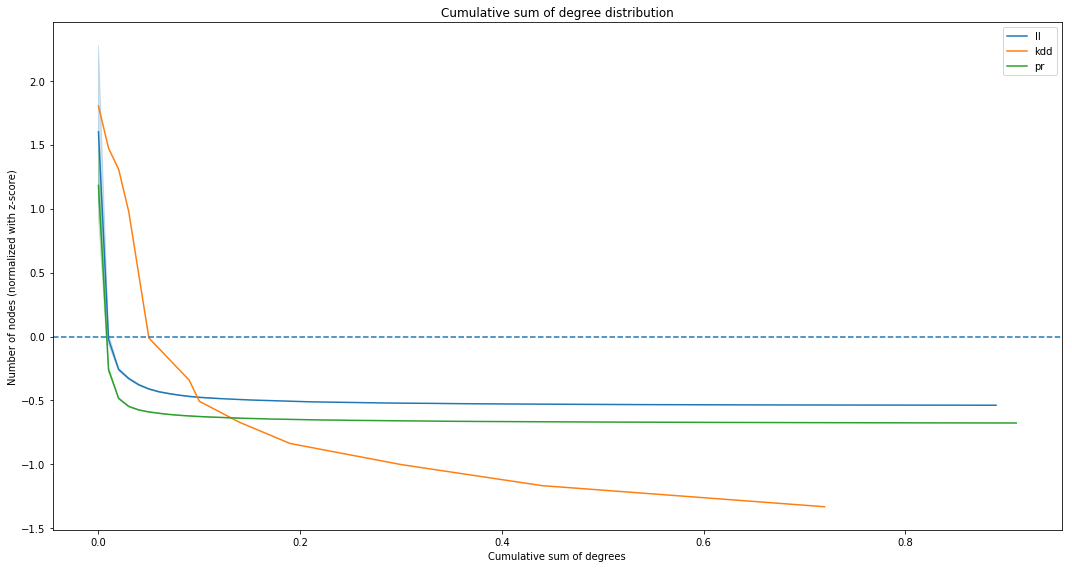

In [8]:
Analysis.plot_compare_cumsum_deg_dist(m)

Cumulative sum of degree distribution shows how the degree is distributed with respect to the number of nodes.

* Nodes with a lower degree (left on the plot) are typically way less than the ones with a high degree (right on the plot).

* Over the dotted line there's a number of node above the mean (the converse below the line) as per z-score.

* Z-score normalization for the number of nodes has been chosen because it preserves the range (maximum and minimum) and introduces the dispersion of the serie (standard deviation / variance)

\begin{align}
P(k) = \frac{\text{# nodes with degree >= k}}{\text{# nodes}}
\end{align}

Cumulative sum of degree distribution is more robust wrt the simple degree distribution because is less subject to small numbers. 

### Communities
Found communities per epsilon parameter.

In [9]:
for data_fn, m_list in m.items():
    print(f'Communities found in {data_fn}')
    display(Analysis.number_of_communities(m_list))

Communities found in ll


epsilon  # communities  # nodes  # edges
0     0.25             11     5998   105479
1     0.50             22     5998   105479

Communities found in kdd


epsilon  # communities  # nodes  # edges
0     0.25             10      103      453
1     0.50             12      103      453

Communities found in pr


epsilon  # communities  # nodes  # edges
0     0.25             92    21802   499205
1     0.50            245    21801   499186

Network analysis per found communities

In [10]:
for data_fn, m_list in m.items():
    print(f'Metrics for {data_fn}')
    for e, m_element in m_list.items():
        print(e)
        display(Analysis.describe_communities(m_element).describe())

Metrics for ll
0.25


# nodes        # edges  avg degree  avg weighted degree    density  \
count    11.000000      11.000000   11.000000            11.000000  11.000000   
mean   1469.909091   32442.090909   24.188445            35.651355   0.321609   
std    2095.936089   44396.989149   20.078803            31.860467   0.339049   
min       4.000000      11.000000    5.500000             6.000000   0.003300   
25%       9.500000      43.500000    8.100000             9.066650   0.010050   
50%      15.000000      68.000000   10.461500            14.769200   0.304800   
75%    2772.000000   77397.000000   38.769850            58.298350   0.534600   
max    5557.000000  101994.000000   56.274200            84.394200   0.916700   

       strongly conn components  avg clustering  assortativity  
count                      11.0       11.000000      11.000000  
mean                        1.0        0.560291      -0.390891  
std                         0.0        0.177963       0.237689  
min                         1.0        0.305500      -0.805200  
25%                         1.0        0.453950      -0.516100  
50%                         1.0        0.564100      -0.257300  
75%                         1.0        0.666050      -0.230400  
max                         1.0        0.833300      -0.182800

0.5


# nodes       # edges  avg degree  avg weighted degree    density  \
count    22.000000     22.000000   22.000000            22.000000  22.000000   
mean   1046.954545  25348.318182   28.176850            43.835177   0.291077   
std    1505.964790  35548.313756   21.461458            35.359051   0.343313   
min       4.000000     10.000000    5.000000             5.000000   0.003700   
25%       7.000000     27.750000    7.166675             7.400000   0.017200   
50%     330.000000   4942.500000   26.034050            43.232450   0.042700   
75%    1928.000000  57857.750000   44.229550            76.689600   0.630525   
max    5142.000000  98093.000000   61.962100           102.178500   0.916700   

       strongly conn components  avg clustering  assortativity  
count                      22.0       22.000000      22.000000  
mean                        1.0        0.566055      -0.416445  
std                         0.0        0.221597       0.218027  
min                         1.0        0.267500      -0.909100  
25%                         1.0        0.390000      -0.595575  
50%                         1.0        0.513600      -0.290400  
75%                         1.0        0.800000      -0.261475  
max                         1.0        0.867000      -0.203100

Metrics for kdd
0.25


# nodes     # edges  avg degree  avg weighted degree    density  \
count  10.000000   10.000000   10.000000            10.000000  10.000000   
mean   11.500000   46.400000    7.545670             9.058180   0.574180   
std     9.119576   40.642616    1.316385             1.836797   0.293217   
min     4.000000   11.000000    5.500000             6.000000   0.150600   
25%     5.250000   17.500000    6.449975             8.045450   0.296375   
50%     6.500000   26.500000    7.811700             9.000000   0.638100   
75%    17.500000   74.750000    8.600025            10.100025   0.825000   
max    30.000000  131.000000    9.400000            12.000000   0.916700   

       strongly conn components  avg clustering  assortativity  
count                      10.0       10.000000      10.000000  
mean                        1.0        0.708600      -0.391480  
std                         0.0        0.121057       0.184305  
min                         1.0        0.528900      -0.751000  
25%                         1.0        0.626750      -0.486225  
50%                         1.0        0.713900      -0.390700  
75%                         1.0        0.821000      -0.253500  
max                         1.0        0.850000      -0.133300

0.5


# nodes    # edges  avg degree  avg weighted degree    density  \
count  12.000000   12.00000   12.000000            12.000000  12.000000   
mean    9.000000   35.25000    7.411875             8.834983   0.634642   
std     6.714976   29.81496    1.259465             1.715924   0.238541   
min     4.000000   11.00000    5.500000             6.000000   0.188300   
25%     5.750000   17.75000    6.249975             8.000000   0.580550   
50%     6.000000   24.50000    7.690500             8.376600   0.666700   
75%     7.750000   33.50000    8.380950             9.783325   0.787525   
max    24.000000  104.00000    9.400000            12.000000   0.916700   

       strongly conn components  avg clustering  assortativity  
count                      12.0       12.000000      12.000000  
mean                        1.0        0.713017      -0.418400  
std                         0.0        0.108058       0.169776  
min                         1.0        0.549000      -0.751000  
25%                         1.0        0.614250      -0.510150  
50%                         1.0        0.738850      -0.444000  
75%                         1.0        0.807000      -0.288650  
max                         1.0        0.850000      -0.133300

Metrics for pr
0.25


# nodes        # edges  avg degree  avg weighted degree  \
count     92.000000      92.000000   92.000000            92.000000   
mean    1467.478261   49155.554348   40.110735            68.953974   
std     2214.467234   78048.169008   28.256969            50.792717   
min        4.000000      10.000000    5.000000             5.000000   
25%        8.750000      37.250000    7.750025             9.477775   
50%      937.500000   24310.000000   49.187050            89.374450   
75%     1532.250000   50686.250000   64.018550           115.644150   
max    10113.000000  327037.000000   82.751400           147.264300   

         density  strongly conn components  avg clustering  assortativity  
count  92.000000                      92.0       92.000000      92.000000  
mean    0.249629                       1.0        0.426053      -0.353285  
std     0.327051                       0.0        0.266903       0.219560  
min     0.003200                       1.0        0.162800      -0.909100  
25%     0.021500                       1.0        0.214700      -0.554400  
50%     0.027850                       1.0        0.255850      -0.236550  
75%     0.547600                       1.0        0.687475      -0.186450  
max     1.250000                       1.0        1.000000      -0.121800

0.5


# nodes        # edges  avg degree  avg weighted degree  \
count   245.000000     245.000000  245.000000           245.000000   
mean    404.183673   11701.902041   18.596824            30.158888   
std    1334.877484   43246.151153   19.290296            32.426648   
min       4.000000      10.000000    5.000000             5.000000   
25%       6.000000      19.000000    6.333300             8.000000   
50%      23.000000     104.000000    9.434000            14.346200   
75%     206.000000    2044.000000   20.200000            39.288900   
max    9849.000000  316718.000000   85.305300           129.318100   

          density  strongly conn components  avg clustering  assortativity  
count  245.000000                     245.0      245.000000     245.000000  
mean     0.359931                       1.0        0.577923      -0.451912  
std      0.321509                       0.0        0.243121       0.212012  
min      0.003000                       1.0        0.156900      -0.955200  
25%      0.064500                       1.0        0.345400      -0.662600  
50%      0.213300                       1.0        0.626200      -0.405200  
75%      0.690500                       1.0        0.800000      -0.258300  
max      1.250000                       1.0        1.000000      -0.001800

Size of found communities

ll


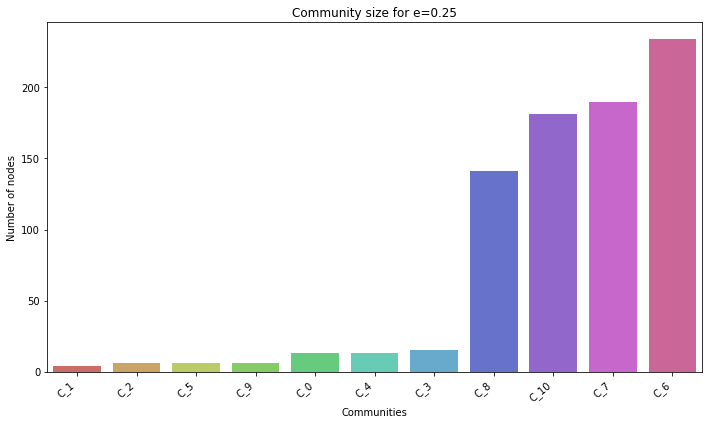

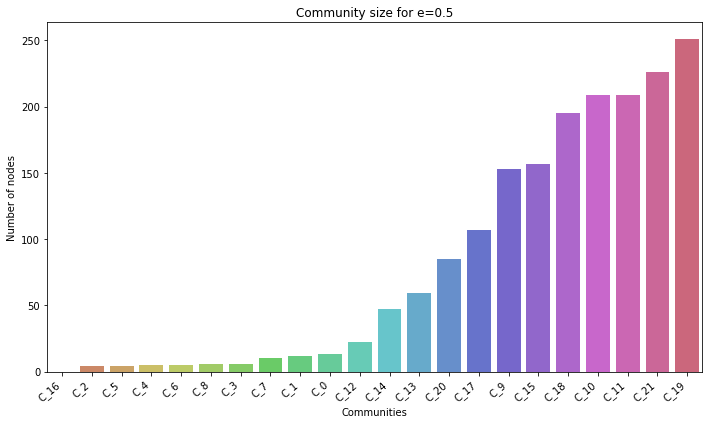

kdd


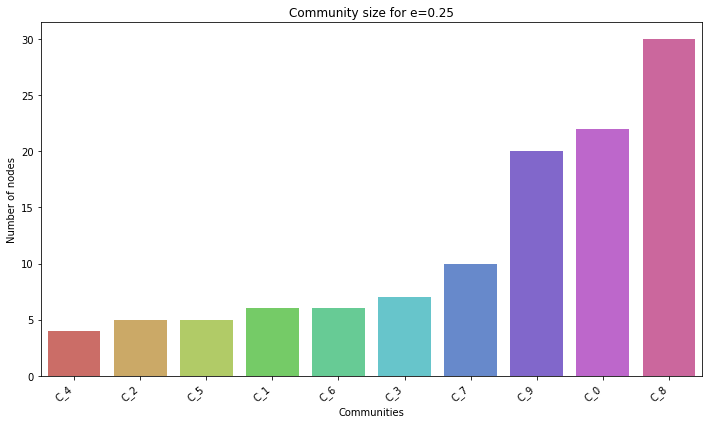

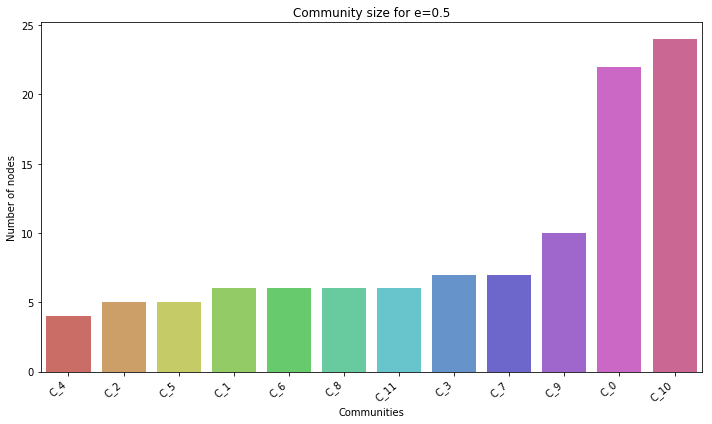

pr


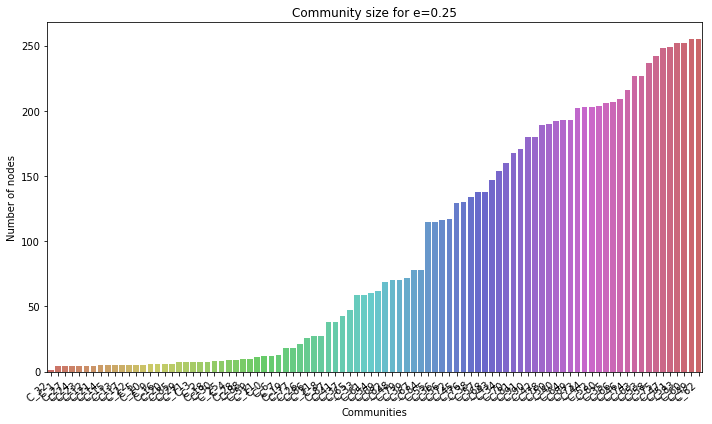

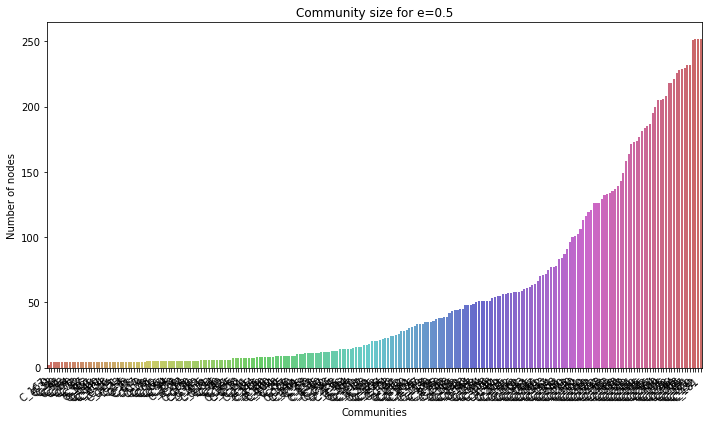

In [11]:
for data_fn, m_list in m.items():
    print(data_fn)
    for e, m_element in m_list.items():
        Analysis.plot_community_size(m_element)

### Communities quality parameters
Survey of modularity measures: https://github.com/Lab41/survey-community-detection 
* *Internal density*: number of edges (ms) in subset S divided by the total number of possible edges between all nodes (ns(ns-1)/2). Higher the better
* *Average degree*: average internal degree across all nodes (ns) in subset S. Higher the better.
* *FOMD (Fraction over median degree)*: Determines the number of nodes that have an internal degree greater than the median degree of nodes in Subset S. Higher the better.
* *Expansion*: can be thought as “External Degree”. Measure of separability. Lower the better.
* *Cut Ratio*: This metric is a measure of separability and can be thought of as "External Density". Lower the better.
* *Conductance*: Ratio of edges inside the cluster to the number of edges leaving the cluster (captures surface area to volume). Higher the better.
* *Normalized Cut*: Represents how well subset S is separated from graph G. Combines Conductance with the fraction of external edges over all non-community edges. Higher the better.
* *Maximum ODF (Out Degree Fraction)*: Fraction of external conections to internal connections for each node (ns) in S. It then returns the fraction with the highest value. Lower the better.
* *Average ODF*: same as Maximum ODF but takes the average. Lower the better.
* *Flake-ODF*: Fraction of the number of nodes that have fewer internal connections than external connections to the number of nodes (ns) in subset S. Higher the better.


In [12]:
for data_fn, m_list in m.items():
    print(f'Communities quality parameters found in {data_fn}')
    for e, pq in Analysis.pquality(m_list):
        print(f'pquality for e={e}')
        display(pq)

Communities quality parameters found in ll
pquality for e=0.25


min            max           avg           std
Index                                                               
Normalized Cut   0.000000       0.859143      0.218898      0.225665
Edges inside     0.001652       0.458333      0.160803      0.161628
Average Degree   5.500000      56.274182     24.188450     19.144379
FOMD             0.200000       0.500000      0.422904      0.107787
Expansion        0.000000      75.891688      8.476845     21.389743
Cut Ratio        0.000000       0.013550      0.001741      0.003773
Edges inside    11.000000  101994.000000  32442.090909  42330.868229
Conductance      0.000000       0.728053      0.136139      0.201031
Maximum-ODF      0.000000    8016.000000   1804.727273   2641.825577
Average-ODF      0.000000     151.783375     16.953690     42.779486
Flake-ODF        0.000000       0.282116      0.046471      0.087375

pquality for e=0.5


min           max           avg           std
Index                                                              
Normalized Cut   0.000000      0.995627      0.468324      0.340627
Edges inside     0.001855      0.458333      0.145536      0.167711
Average Degree   5.000000     61.962128     28.176855     20.968030
FOMD             0.166667      0.500000      0.428910      0.101187
Expansion        0.000000    212.042553     38.675862     55.295514
Cut Ratio        0.000000      0.035631      0.006949      0.009306
Edges inside    10.000000  98093.000000  25348.318182  34731.001889
Conductance      0.000000      0.959596      0.370258      0.342143
Maximum-ODF      0.000000   8602.000000   3672.636364   3434.541991
Average-ODF      0.000000    424.085106     77.351724    110.591027
Flake-ODF        0.000000      1.000000      0.166352      0.234692

Communities quality parameters found in kdd
pquality for e=0.25


min         max        avg        std
Index                                                      
Normalized Cut   0.000000    0.186669   0.063213   0.068722
Edges inside     0.075287    0.458333   0.287084   0.139085
Average Degree   5.500000    9.400000   7.545671   1.248829
FOMD             0.200000    0.500000   0.392056   0.098580
Expansion        0.000000    1.300000   0.463788   0.489593
Cut Ratio        0.000000    0.017808   0.005506   0.006047
Edges inside    11.000000  131.000000  46.400000  38.556971
Conductance      0.000000    0.155556   0.051994   0.055843
Maximum-ODF      0.000000   30.000000   6.800000   9.042124
Average-ODF      0.000000    2.600000   0.927576   0.979185
Flake-ODF        0.000000    0.100000   0.021212   0.034657

pquality for e=0.5


min         max        avg        std
Index                                                      
Normalized Cut   0.000000    0.366827   0.098976   0.113437
Edges inside     0.094156    0.458333   0.317317   0.114187
Average Degree   5.500000    9.400000   7.411869   1.205837
FOMD             0.166667    0.500000   0.386039   0.118012
Expansion        0.000000    3.166667   0.842343   1.014667
Cut Ratio        0.000000    0.032646   0.008895   0.010432
Edges inside    11.000000  104.000000  35.250000  28.545651
Conductance      0.000000    0.345455   0.090808   0.106959
Maximum-ODF      0.000000   20.000000   7.500000   7.444237
Average-ODF      0.000000    6.333333   1.684686   2.029333
Flake-ODF        0.000000    0.333333   0.072736   0.115772

Communities quality parameters found in pr
pquality for e=0.25


min            max           avg           std
Index                                                               
Normalized Cut   0.000000       1.045033      0.522919      0.382968
Edges inside     0.001599       0.625000      0.124816      0.162635
Average Degree   5.000000      82.751361     40.110734     28.102975
FOMD             0.000000       0.500000      0.435473      0.098469
Expansion        0.000000     351.990769     85.089145     92.332701
Cut Ratio        0.000000       0.016389      0.004138      0.004353
Edges inside    10.000000  327037.000000  49155.554348  77622.835221
Conductance      0.000000       0.952922      0.422098      0.325736
Maximum-ODF      0.000000   10880.000000   6252.673913   4901.216072
Average-ODF      0.000000     703.981538    170.178289    184.665403
Flake-ODF        0.000000       0.592133      0.251206      0.210324

pquality for e=0.5


min            max           avg           std
Index                                                               
Normalized Cut   0.000000       1.030688      0.739286      0.314657
Edges inside     0.001519       0.625000      0.179968      0.160427
Average Degree   5.000000      85.305263     18.596825     19.250886
FOMD             0.000000       0.500000      0.416061      0.097705
Expansion        0.000000    1335.500000    129.457001    148.086890
Cut Ratio        0.000000       0.061270      0.006012      0.006826
Edges inside    10.000000  316718.000000  11701.902041  43157.803458
Conductance      0.000000       0.996270      0.706944      0.310684
Maximum-ODF      0.000000   10964.000000   4358.938776   4335.601294
Average-ODF      0.000000    2671.000000    258.914002    296.173780
Flake-ODF        0.000000       1.000000      0.445666      0.259628

### Similarities
Detect similarities between communities of the same partition.
1. get the top 10 nodes in each community wrt the given metric ("indegree" in this case)
2. apply Kendall-Tau given a pair of top 10 ranked communities

Metrics:
* *Kendall Tau*: it takes values between ±1, with a positive correlation indicating that the ranks of
both variables increase together whilst a negative correlation indicates that as the rank of one variable increases the other one decreases.

  source: [2001 Blackwell Science Ltd, Journal of Clinical Nursing](http://www.blackwellpublishing.com/specialarticles/jcn_10_715.pdf)

\begin{align}
\tau = \frac{(\text{# of concordant pairs}) - (\text{# of disconcordant pairs})}
{N \cdot (N-1)/2}
\end{align}

 * *Indegree*: number of edges entering a node in a direct graph.

* *H-Index*: According to the definition of h-index on Wikipedia:
"A scientist has index h if h of his/her N papers have at least h citations each, and the other N − h papers have no more than h citations each."
For example, given citations = [3, 0, 6, 1, 5], which means the researcher has 5 papers in total and each of them had received 3, 0, 6, 1, 5 citations respectively.
Since the researcher has 3 papers with at least 3 citations each and the remaining two with no more than 3 citations each, his h-index is 3.

  Note: If there are several possible values for h, the maximum one is taken as the h-index.

  source: [Leetcode's Github](https://github.com/kamyu104/LeetCode/blob/master/Python/h-index.py)

#### Similarities between SAME epsilon settings
Find similarities between communities of the same partition settings (since we are using overlapping commmunities detection).

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


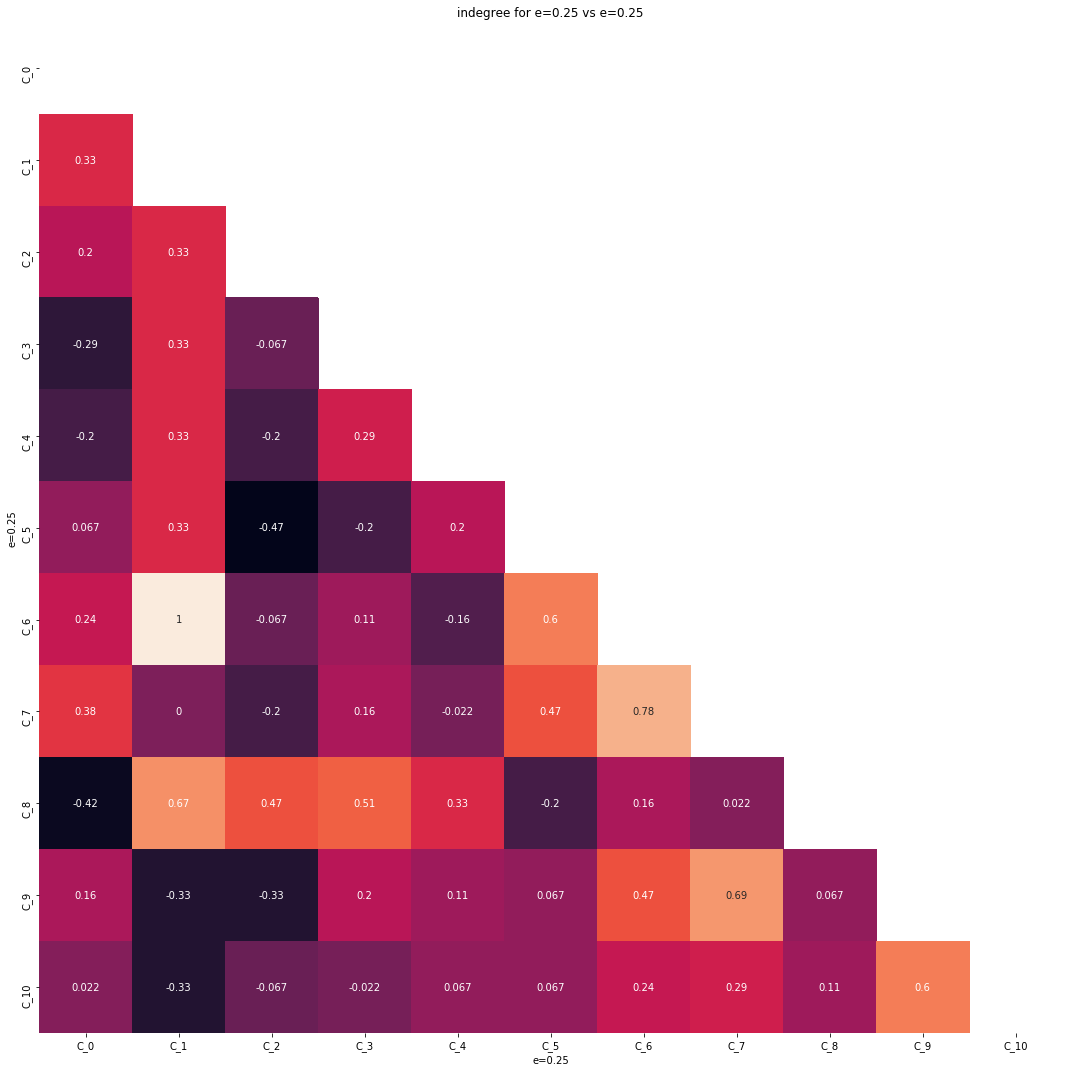

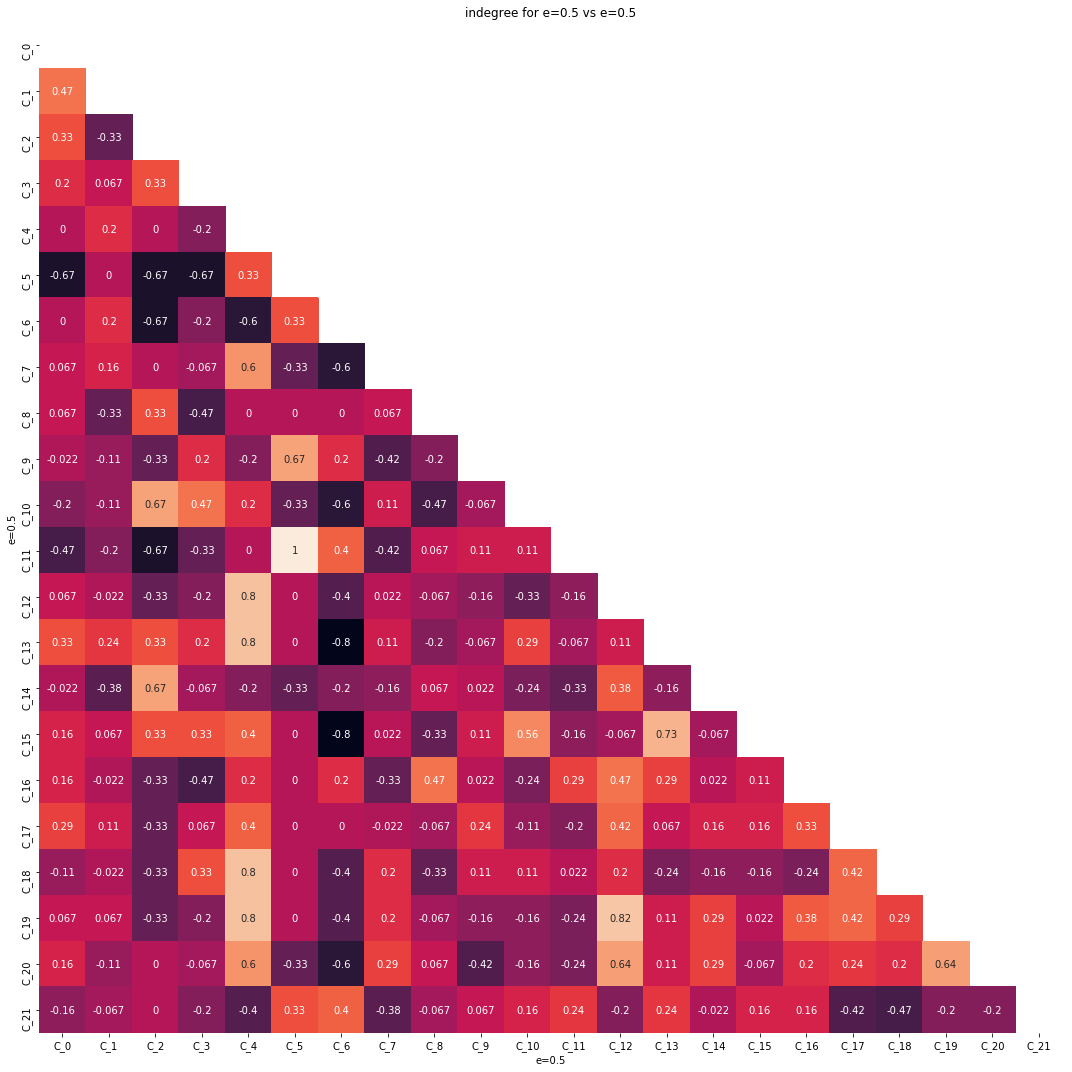

heatmaps for dataset kdd


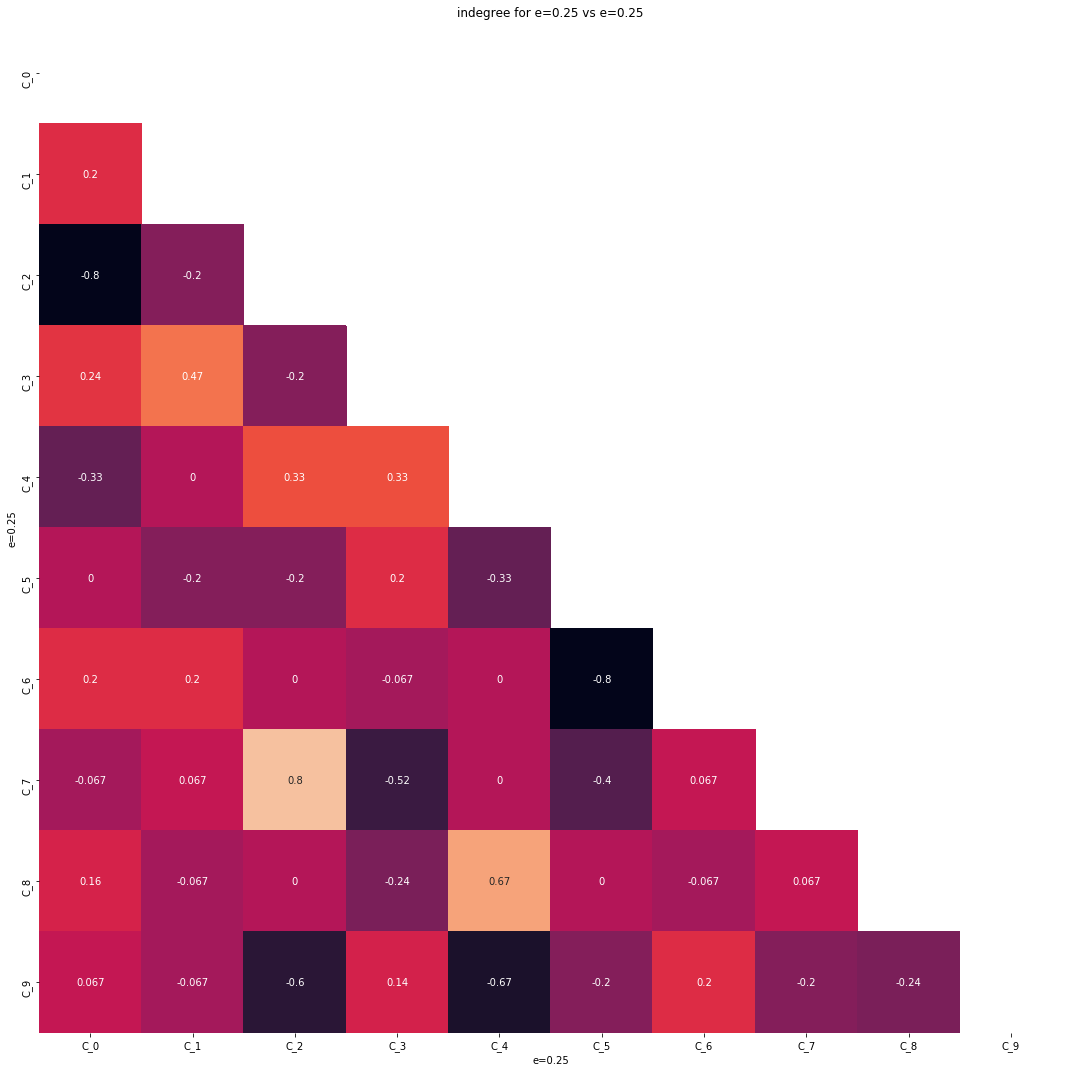

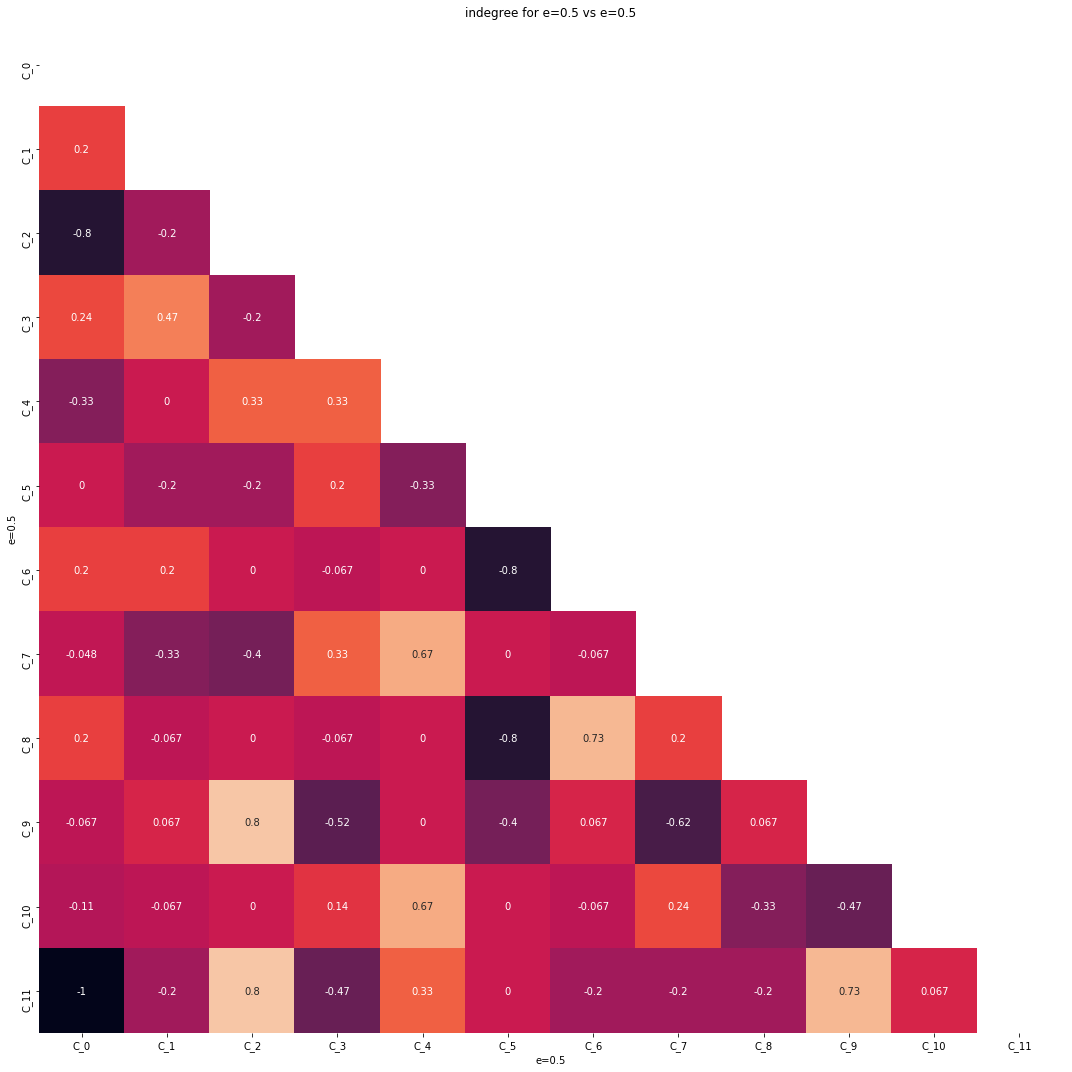

heatmaps for dataset pr


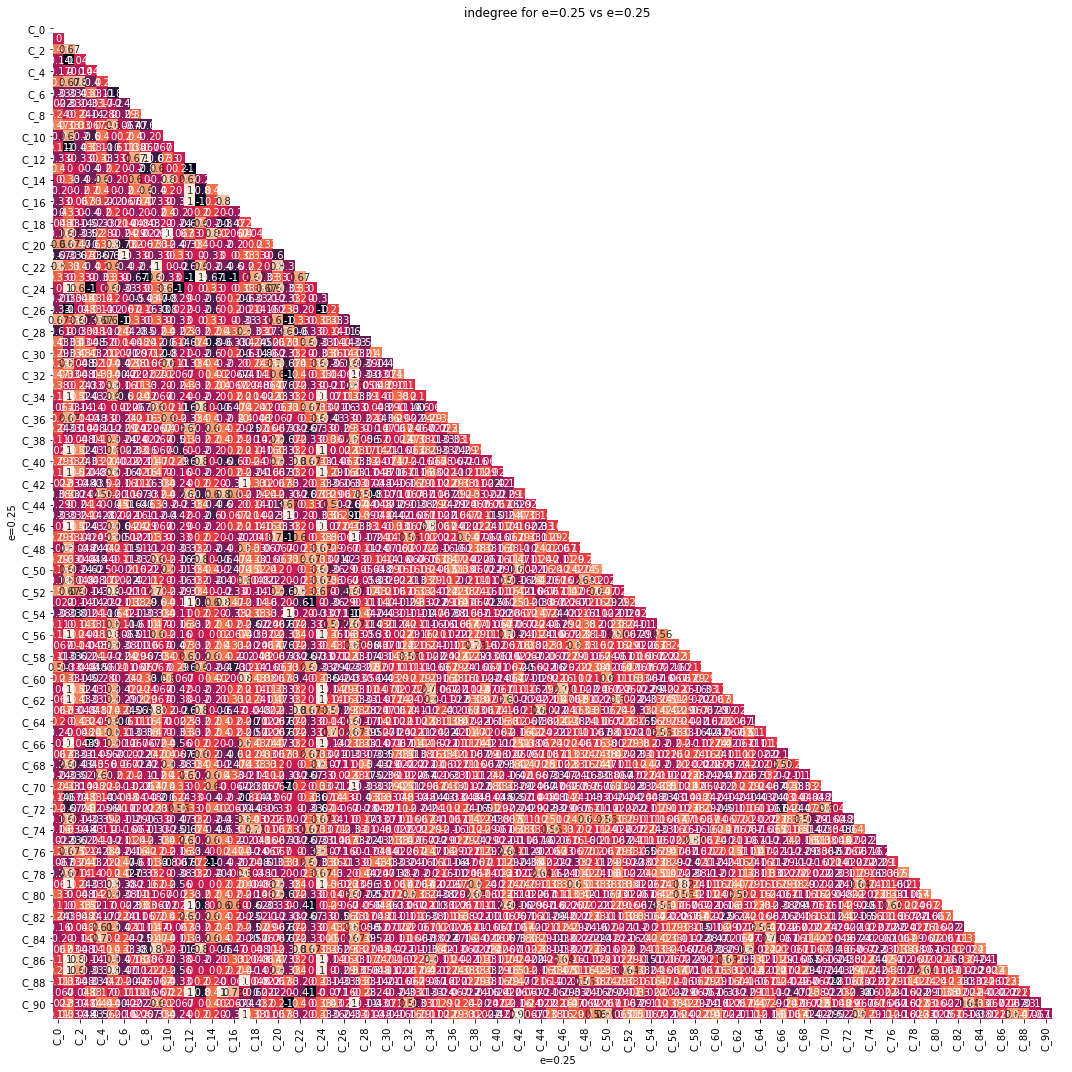

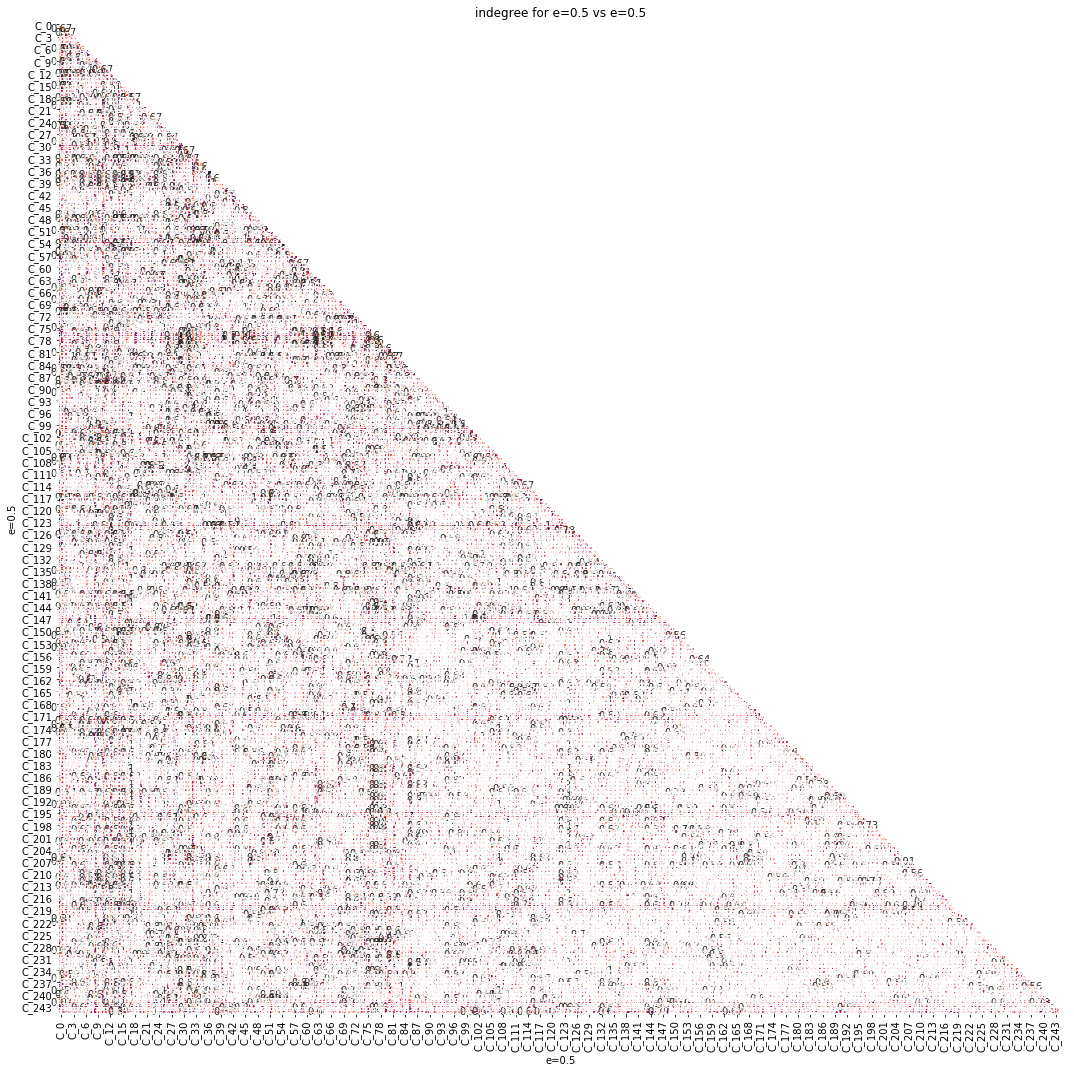

In [13]:
for data_fn, m_list in m.items():
    print(f'heatmaps for dataset {data_fn}')
    Analysis.communities_top_users_heatmap(m_list, metric_name, e_pairs, triangular=True)

In [14]:
for data_fn, m_list in m.items():
    print(f'rankings for dataset {data_fn}')
    r_list = Analysis.communities_top_users_rank(m_list, metric_name, e_pairs, threshold=0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


p1_e0.25 p2_e0.25  indegree
0      C_1      C_6      1.00
1      C_6      C_7      0.78
2      C_7      C_9      0.69
3      C_1      C_8      0.67
4     C_10      C_9      0.60
5      C_5      C_6      0.60

p1_e0.5 p2_e0.5  indegree
0     C_11     C_5      1.00
1     C_12    C_19      0.82
2     C_19     C_4      0.80
3     C_18     C_4      0.80
4     C_13     C_4      0.80
5     C_12     C_4      0.80
6     C_13    C_15      0.73
7     C_14     C_2      0.67
8     C_10     C_2      0.67
9      C_5     C_9      0.67
10    C_19    C_20      0.64
11    C_12    C_20      0.64
12    C_20     C_4      0.60
13     C_4     C_7      0.60

rankings for dataset kdd


p1_e0.25 p2_e0.25  indegree
0      C_2      C_7      0.80
1      C_4      C_8      0.67

p1_e0.5 p2_e0.5  indegree
0    C_11     C_2      0.80
1     C_2     C_9      0.80
2    C_11     C_9      0.73
3     C_6     C_8      0.73
4    C_10     C_4      0.67
5     C_4     C_7      0.67

rankings for dataset pr


p1_e0.25 p2_e0.25  indegree
0       C_27     C_90       1.0
1       C_27     C_70       1.0
2       C_27     C_47       1.0
3       C_27     C_32       1.0
4       C_24     C_87       1.0
5       C_24     C_86       1.0
6       C_24     C_79       1.0
7       C_24     C_66       1.0
8       C_24     C_62       1.0
9       C_24     C_61       1.0
10      C_24     C_56       1.0
11      C_24     C_46       1.0
12      C_24     C_41       1.0
13      C_24     C_39       1.0
14      C_24     C_34       1.0
15      C_21     C_54       1.0
16      C_21     C_45       1.0
17      C_21      C_6       1.0
18      C_13     C_23       1.0
19      C_12     C_89       1.0
20      C_12     C_81       1.0
21      C_12     C_53       1.0
22      C_12     C_16       1.0
23      C_12     C_15       1.0
24      C_12      C_8       1.0
25       C_1     C_87       1.0
26       C_1     C_86       1.0
27       C_1     C_79       1.0
28       C_1     C_66       1.0
29       C_1     C_62       1.0
..       ...      ...       ...
222     C_14     C_69       0.6
223     C_14     C_58       0.6
224     C_14     C_53       0.6
225     C_14     C_43       0.6
226     C_14     C_37       0.6
227     C_14      C_7       0.6
228     C_14      C_4       0.6
229     C_13     C_67       0.6
230     C_13     C_59       0.6
231     C_13     C_22       0.6
232     C_13     C_18       0.6
233     C_13      C_9       0.6
234     C_10     C_68       0.6
235     C_10     C_60       0.6
236     C_10     C_50       0.6
237     C_10     C_36       0.6
238     C_10     C_31       0.6
239      C_9     C_90       0.6
240      C_5     C_86       0.6
241      C_5     C_83       0.6
242      C_5     C_80       0.6
243      C_5     C_66       0.6
244      C_5     C_65       0.6
245      C_5     C_64       0.6
246      C_5     C_62       0.6
247      C_5     C_61       0.6
248      C_5     C_57       0.6
249      C_5     C_55       0.6
250      C_5      C_9       0.6
251      C_0     C_20       0.6

[252 rows x 3 columns]

p1_e0.5 p2_e0.5  indegree
0      C_242    C_25       1.0
1      C_241    C_82       1.0
2      C_241    C_28       1.0
3      C_239    C_25       1.0
4      C_238    C_64       1.0
5      C_236     C_9       1.0
6      C_235    C_82       1.0
7      C_235    C_28       1.0
8      C_234    C_31       1.0
9      C_234     C_5       1.0
10     C_233    C_72       1.0
11     C_230    C_82       1.0
12     C_230    C_28       1.0
13     C_229    C_25       1.0
14     C_227    C_64       1.0
15     C_226    C_96       1.0
16     C_226    C_70       1.0
17     C_226    C_53       1.0
18     C_226    C_26       1.0
19     C_222     C_9       1.0
20     C_221    C_25       1.0
21     C_219    C_82       1.0
22     C_219    C_28       1.0
23     C_217    C_87       1.0
24     C_214    C_23       1.0
25     C_213    C_48       1.0
26     C_213    C_33       1.0
27     C_212    C_87       1.0
28     C_210    C_87       1.0
29     C_209    C_23       1.0
...      ...     ...       ...
2169    C_12   C_242       0.6
2170    C_12   C_239       0.6
2171    C_12   C_229       0.6
2172    C_12   C_228       0.6
2173    C_12   C_221       0.6
2174    C_12   C_207       0.6
2175    C_12   C_206       0.6
2176    C_12   C_193       0.6
2177    C_12   C_138       0.6
2178    C_12   C_135       0.6
2179    C_12    C_86       0.6
2180    C_12    C_85       0.6
2181    C_12    C_81       0.6
2182    C_12    C_75       0.6
2183    C_12     C_3       0.6
2184    C_10   C_199       0.6
2185    C_10   C_112       0.6
2186    C_10   C_106       0.6
2187    C_10    C_89       0.6
2188     C_8    C_98       0.6
2189     C_8    C_85       0.6
2190     C_6    C_68       0.6
2191     C_3    C_85       0.6
2192     C_3    C_71       0.6
2193     C_3    C_49       0.6
2194     C_3     C_8       0.6
2195     C_3     C_6       0.6
2196     C_2    C_71       0.6
2197     C_2    C_57       0.6
2198     C_2     C_6       0.6

[2199 rows x 3 columns]

#### Similarities between DIFFERENT epsilon settings
Epsilon parameter defines the likeliness of creating new communities.

Thus the most important partitions will likely "survive" with different epsilon settings.

Since we are comparing different partitions the heatmap is not triangular as before.

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


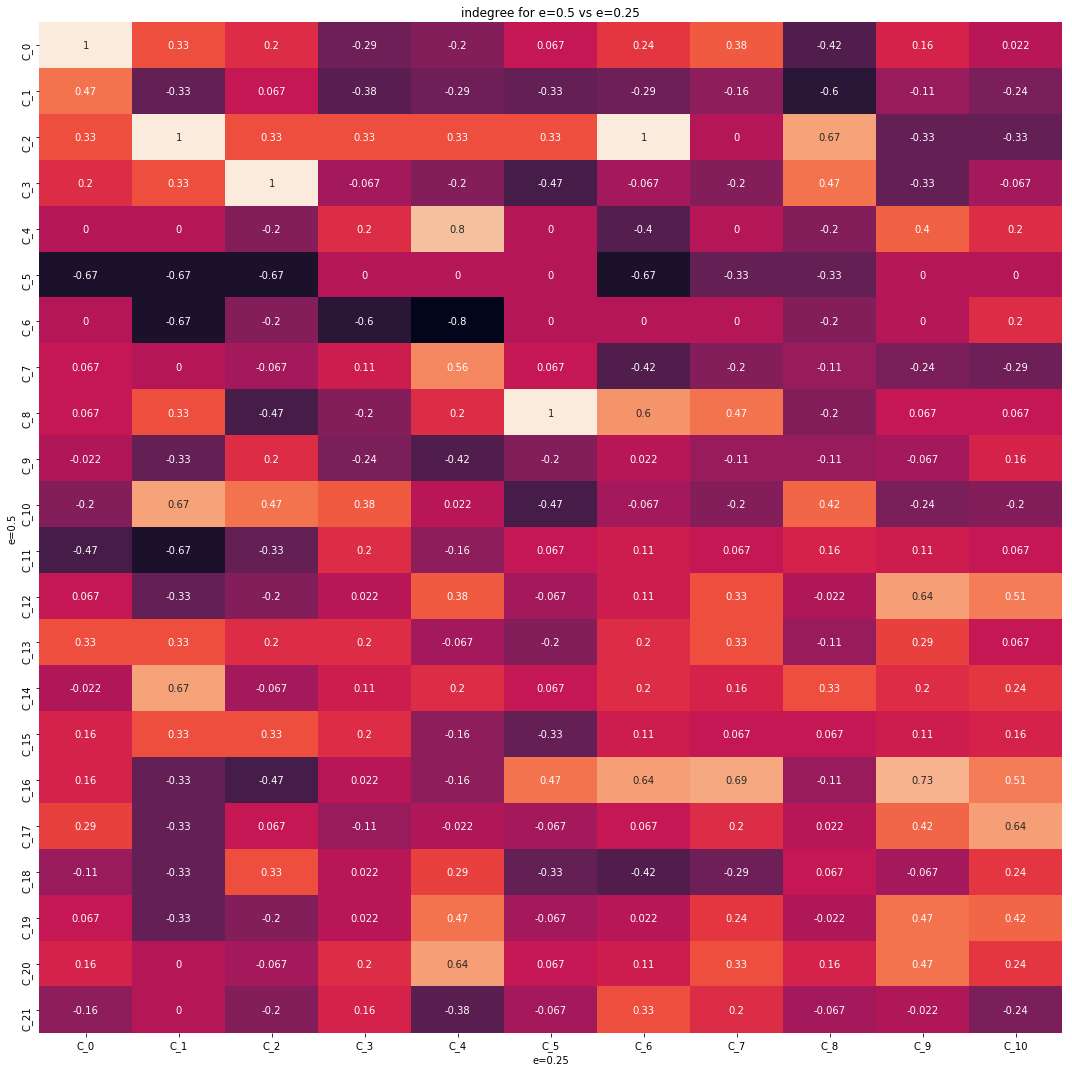

heatmaps for dataset kdd


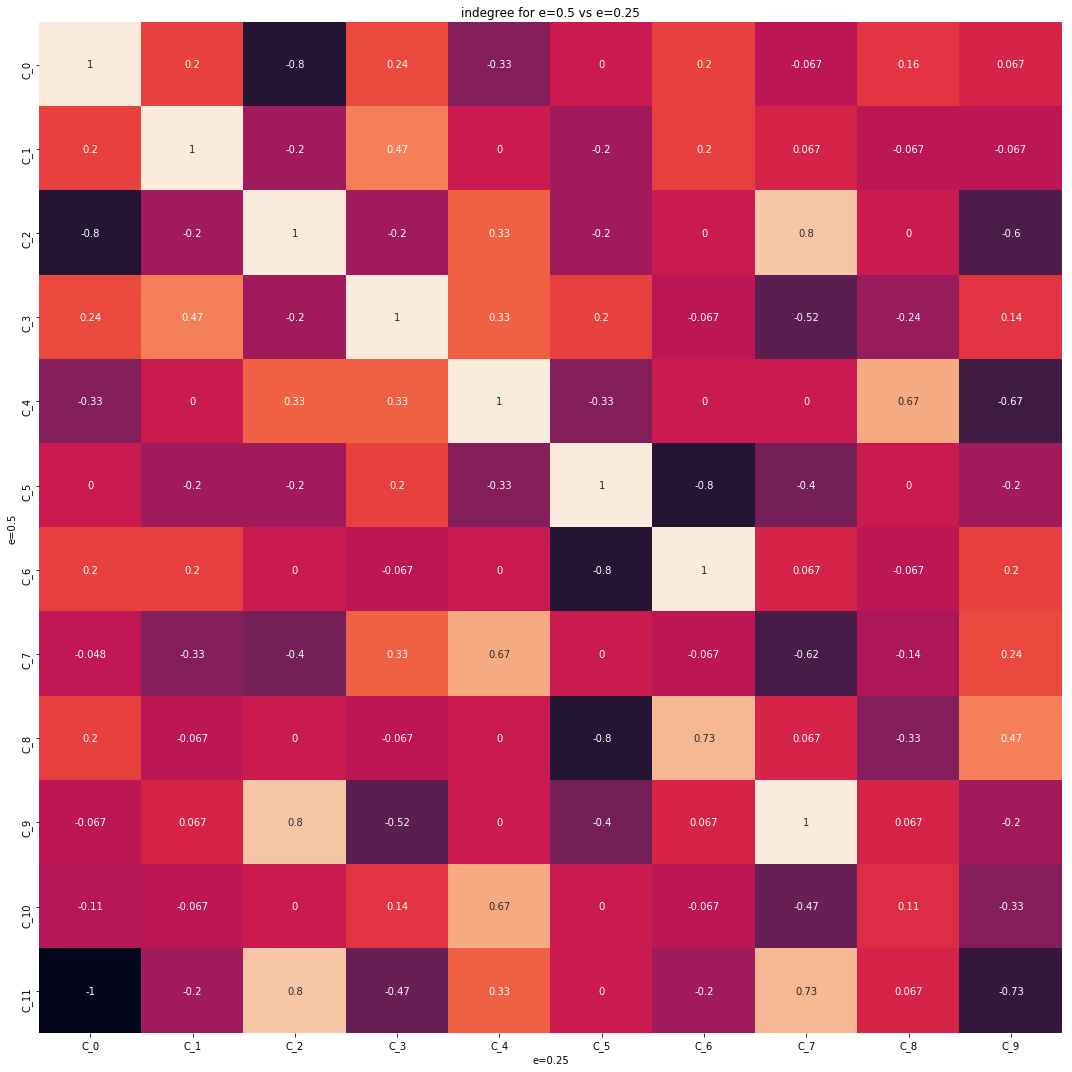

heatmaps for dataset pr


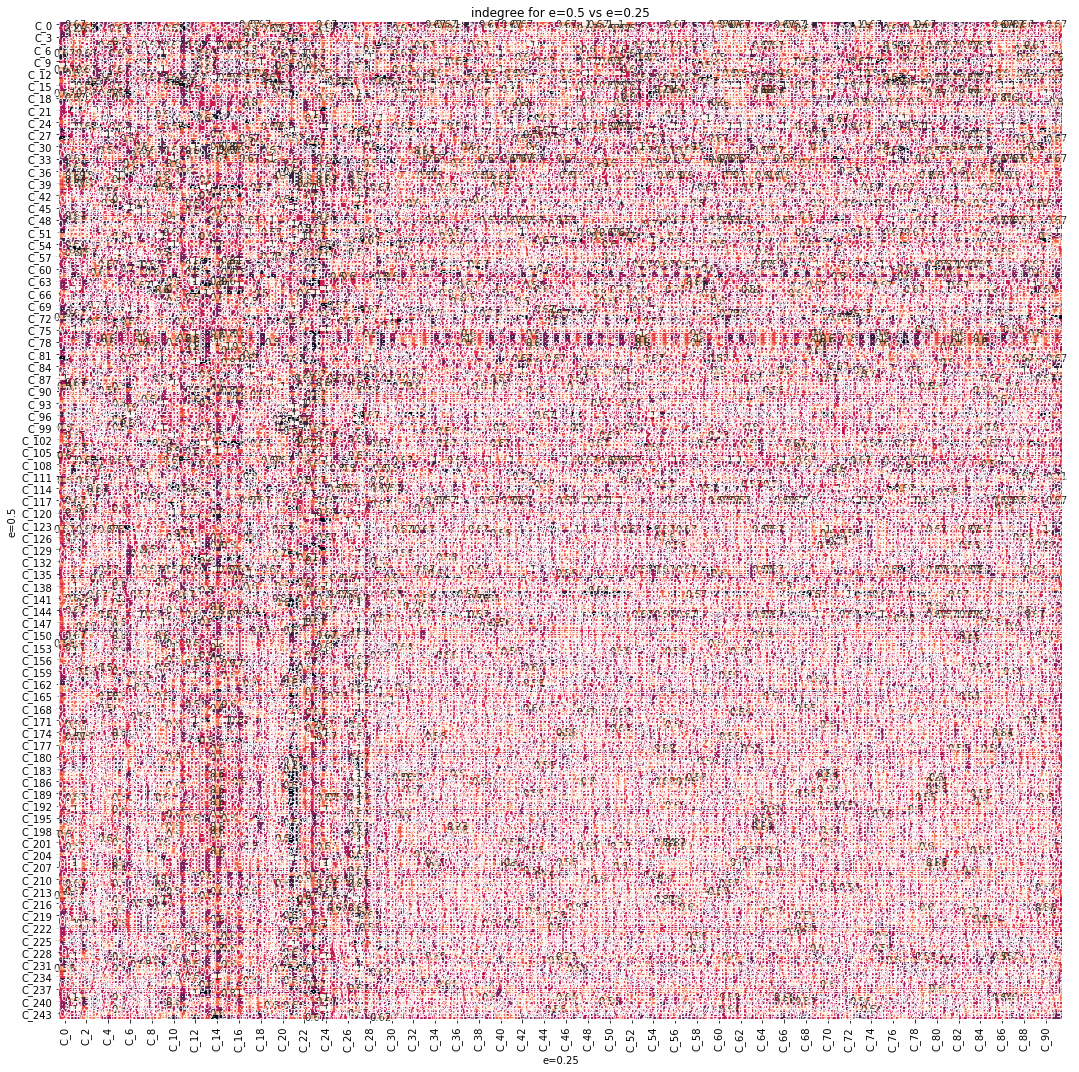

In [15]:
for data_fn, m_list in m.items():
    print(f'heatmaps for dataset {data_fn}')
    Analysis.communities_top_users_heatmap(m_list, metric_name, e_pairwise_combs)

In [16]:
for data_fn in data_filenames:
    print(f'rankings for dataset {data_fn}')
    r_list = Analysis.communities_top_users_rank(m[data_fn], metric_name, e_pairwise_combs, threshold=0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Empty DataFrame
Columns: [p1_e0.5, p2_e0.25, indegree]
Index: []

rankings for dataset kdd


p1_e0.5 p2_e0.25  indegree
0     C_6      C_8      0.73
1     C_4      C_7      0.67

rankings for dataset pr


p1_e0.5 p2_e0.25  indegree
0      C_67      C_9       1.0
1      C_63      C_7       1.0
2      C_58     C_59       1.0
3      C_54     C_70       1.0
4      C_53     C_64       1.0
5      C_49      C_9       1.0
6      C_45     C_70       1.0
7      C_45     C_53       1.0
8      C_43      C_5       1.0
9      C_42     C_51       1.0
10     C_40      C_7       1.0
11     C_37     C_59       1.0
12     C_35      C_9       1.0
13     C_30     C_72       1.0
14     C_28     C_82       1.0
15     C_27     C_43       1.0
16     C_27      C_4       1.0
17     C_25     C_72       1.0
18     C_24     C_75       1.0
19     C_24     C_65       1.0
20     C_24     C_57       1.0
21     C_24     C_25       1.0
22     C_23     C_66       1.0
23     C_23     C_40       1.0
24     C_22      C_7       1.0
25     C_21     C_70       1.0
26     C_21     C_53       1.0
27     C_21     C_49       1.0
28     C_21     C_45       1.0
29     C_21     C_26       1.0
..      ...      ...       ...
378    C_15     C_44       0.6
379    C_14     C_90       0.6
380    C_14     C_77       0.6
381    C_14     C_76       0.6
382    C_14     C_67       0.6
383    C_14     C_46       0.6
384    C_14     C_30       0.6
385    C_14     C_27       0.6
386    C_13     C_86       0.6
387    C_13     C_52       0.6
388    C_13     C_42       0.6
389    C_13     C_38       0.6
390    C_11     C_77       0.6
391    C_11     C_36       0.6
392    C_10     C_68       0.6
393    C_10     C_65       0.6
394    C_10     C_63       0.6
395    C_10     C_57       0.6
396    C_10     C_47       0.6
397    C_10     C_41       0.6
398    C_10     C_35       0.6
399    C_10     C_34       0.6
400     C_7     C_78       0.6
401     C_7     C_76       0.6
402     C_5     C_75       0.6
403     C_5     C_52       0.6
404     C_4     C_78       0.6
405     C_4     C_77       0.6
406     C_3     C_61       0.6
407     C_0     C_89       0.6

[408 rows x 3 columns]

## Comparisons
Compare DEMON community results with other community detection algorithms.

Find similarities between partitions found by different community detection algorithms with a heatmap and then list the most correlated communities.

heatmaps for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


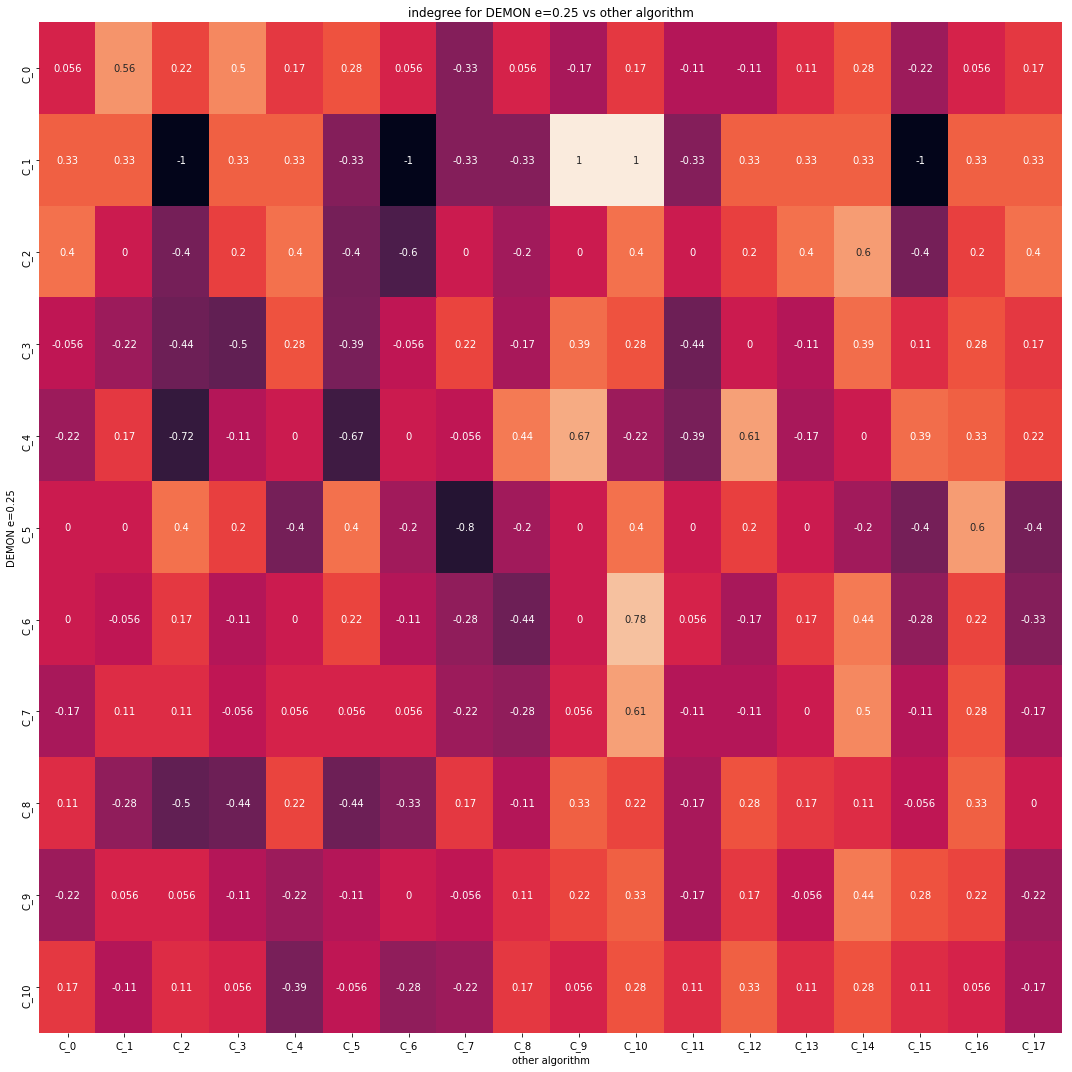

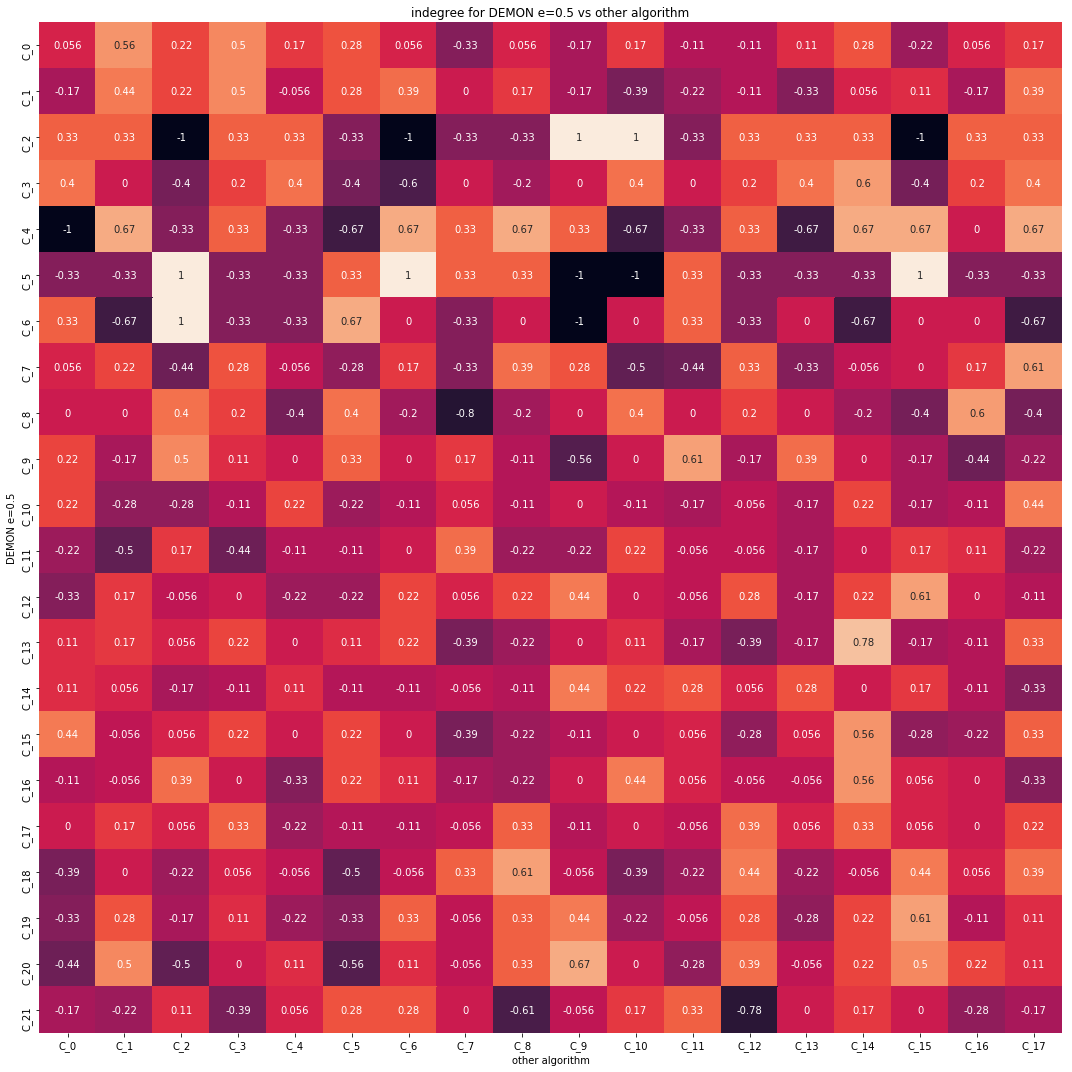

heatmaps for dataset kdd


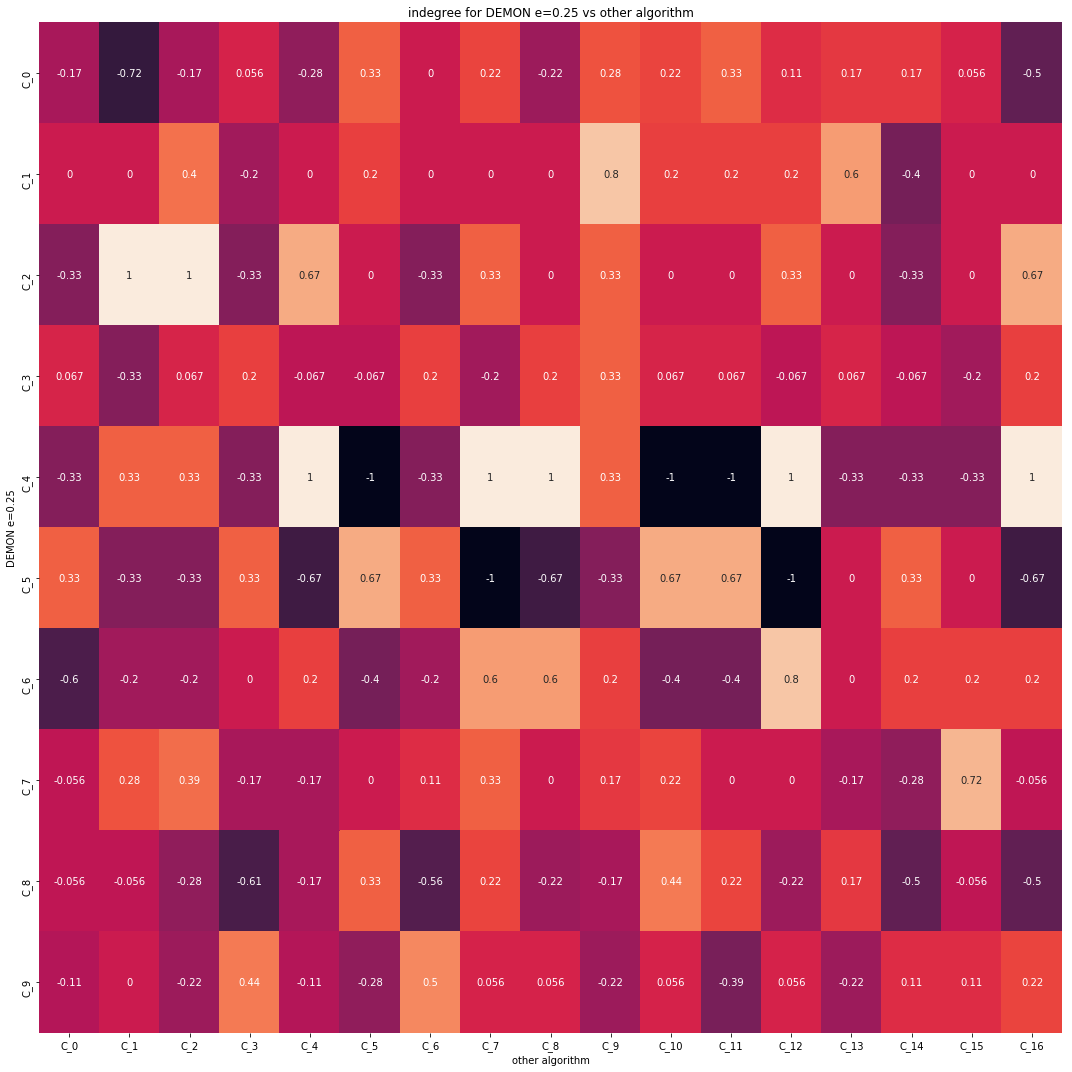

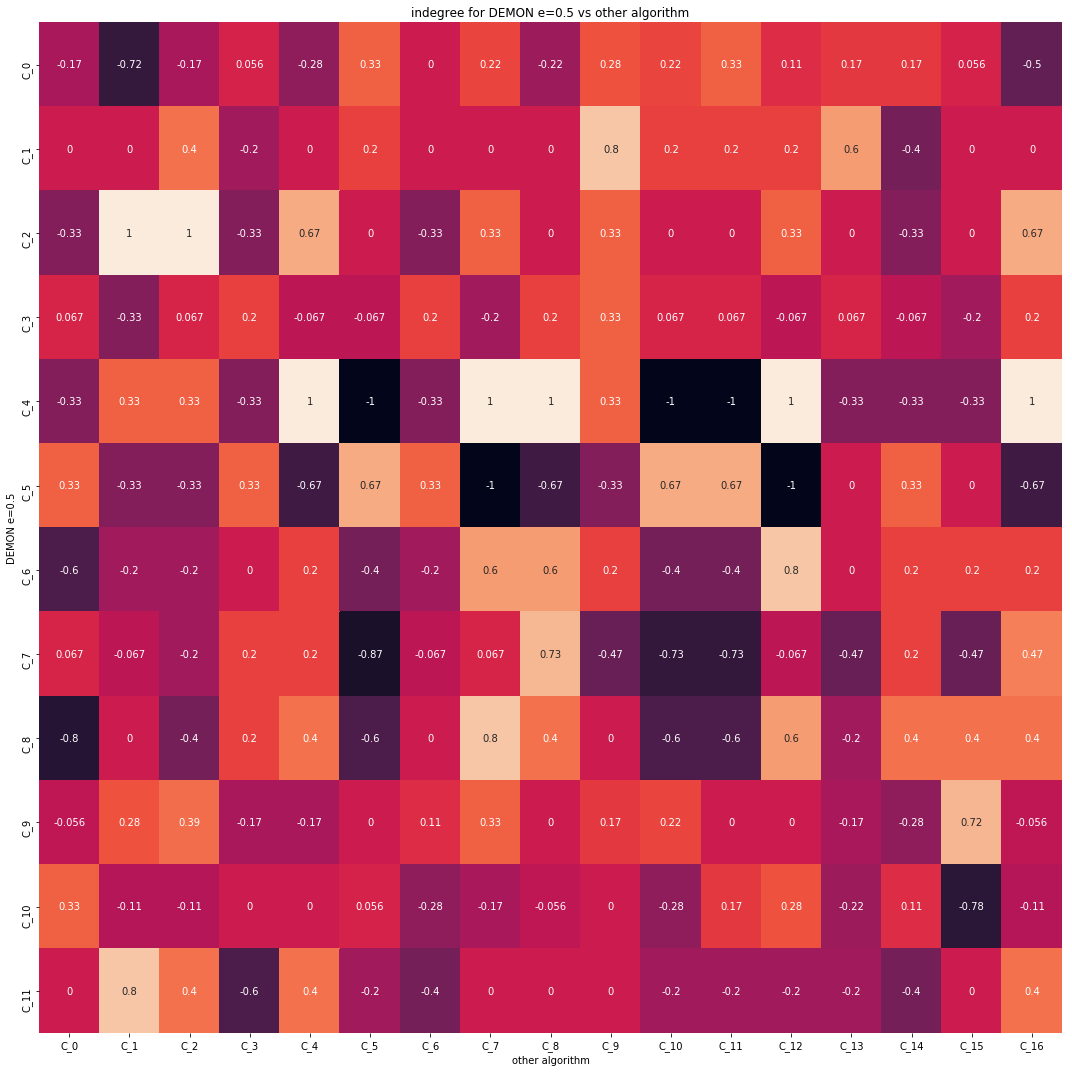

heatmaps for dataset pr


ValueError: invalid literal for int() with base 10: ''

In [17]:
for data_fn, m_list in m.items():
    print(f'heatmaps for dataset {data_fn}')
    c = Comparisons.get_comparison_top_community(m_list[epsilon[0]])
    Comparisons.communities_top_users_heatmap(m_list, c, metric_name)

In [18]:
for data_fn, m_list in m.items():
    print(f'rankings for dataset {data_fn}')
    c = Comparisons.get_comparison_top_community(m_list[epsilon[0]])
    r_list = Comparisons.communities_top_users_rank(m_list, c, metric_name, 0.6)
    for r in r_list:
        display(r.round(2))

rankings for dataset ll


/home/flaprimo/Development/Workspaces/ZikaProject/Python/twitter-network-analysis/venv/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Empty DataFrame
Columns: [DEMON e=0.25, other algorithm, indegree]
Index: []

DEMON e=0.5 other algorithm  indegree
0         C_2             C_6      1.00
1         C_2             C_5      1.00
2         C_5             C_6      0.67

rankings for dataset kdd


DEMON e=0.25 other algorithm  indegree
0          C_1             C_2       1.0

DEMON e=0.5 other algorithm  indegree
0         C_1             C_2      1.00
1         C_7             C_8      0.80
2         C_1            C_11      0.80
3        C_11             C_5      0.67

rankings for dataset pr


ValueError: invalid literal for int() with base 10: ''